# Text Comparison Metrics for Modification Detection

While NLP and generative AI have seen exponential growth, how to efficiently evaluate the success of such techniques remains widely unexplored in the literature. In the context of text generation, ... Often times, the relevance of text generation is in its content more so than the semantics, however, most solutions focus on n-gram similarity metrics which miss the mark on This is especially true for longer texts of technical nature, where even slight variations in wording may change the meaning in particularly compromising ways. 

In this notebook, we will explore various metrics to detect and quantify text modifications. These algorithms, born out of the field of Natural Language Processing (NLP) and Machine Learning, can help us understand the degree of similarity or difference between two pieces of text.

Below are the metrics we will be covering:

1. **Edit Distance (Levenshtein Distance)**: This algorithm computes the minimum number of operations (insertions, deletions, substitutions) required to transform one string into another. 

2. **Cosine Similarity**: This measure calculates the cosine of the angle between two vectors representing the texts. A cosine value close to 1 implies high similarity. This is often used in combination with TF-IDF or word embeddings. Read more [here](https://en.wikipedia.org/wiki/Cosine_similarity).

3. **Jaccard Similarity**: Defined as the size of the intersection divided by the size of the union of the sample sets. It is commonly used to compare the similarity and diversity of sample sets. For more information, refer to [this link](https://en.wikipedia.org/wiki/Jaccard_index).

4. **BLEU (Bilingual Evaluation Understudy)**: Initially designed for evaluating machine translation, BLEU can be used for general text comparison. You can read the original [BLEU paper here](https://www.aclweb.org/anthology/P02-1040.pdf).

5. **ROUGE (Recall-Oriented Understudy for Gisting Evaluation)**: ROUGE is a set of metrics used for evaluating automatic summarization and machine translation. Read the [original paper](https://www.aclweb.org/anthology/W04-1013.pdf) for more insights.

6. **Word Mover's Distance (WMD)**: WMD uses word embeddings to calculate the "distance" between two documents. This is described in detail in the [original WMD paper](http://proceedings.mlr.press/v37/kusnerb15.pdf).

7. **Semantic Similarity Measures** using transformer models: Models such as BERT, RoBERTa, and others can be used to compute a semantic similarity score between two texts. The [BERT paper](https://arxiv.org/abs/1810.04805) is a good starting point for understanding these models.

8. **Cross Encoders**:

9. **BM25**:

10. **Graph Similarity**:

Each of these metrics has its strengths and weaknesses, and the choice depends on the specific requirements of the task at hand. In the upcoming sections of this notebook, we will delve deeper into each of these methods, understand their implementation, and interpret their results. Let's get started!

In [23]:
# !pip install sentence-transformers
# !pip install tensorflow_hub
# import os
# os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'
!pip install rank_bm25

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [1]:
import pandas as pd
import string
from nltk.corpus import stopwords

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

import tensorflow_hub as hub
from nltk.translate.bleu_score import sentence_bleu

import nltk
nltk.download('stopwords')
nltk.download('punkt')
import time 

2023-06-14 20:09:09.009512: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Text Cleaning 

To improve performance of similarity algorithms, some propose to remove non-meaningful words from the text, thereby increasing the amount of 'relevant' informaiton compared

In [2]:
def remove_punctuations(txt, punct = set(string.punctuation)):
    '''
    Removes punctuations from a given text.
    
    Parameters
    ----------
    txt : str
        The input text from which punctuations are to be removed.
    punct : set, optional
        The set of punctuation characters to be removed. Default is all punctuation characters.
    
    Returns
    -------
    str
        The input text with all specified punctuation characters removed.
    '''
    return ''.join([c for c in txt.lower() if c not in punct])

  
def remove_stopwords(txt, sw = set(stopwords.words('english'))):
    '''
    Removes stopwords from a given text.
    
    Parameters
    ----------
    txt : str
        The input text from which stopwords are to be removed.
    sw : set, optional
        The set of stopwords to be removed. Default is English stopwords from NLTK corpus.
    
    Returns
    -------
    str
        The input text with all specified stopwords removed.
    '''
    return ' '.join([w for w in txt.split() if w not in sw])


def clean_text(txt):
    '''
    Cleans a given text by removing specific line feed characters, punctuations and stopwords.
    
    Parameters
    ----------
    txt : str
        The input text to be cleaned.
    
    Returns
    -------
    str
        The cleaned text, with line feed characters, punctuations and stopwords removed and converted to lowercase.
    '''
    txt = txt.replace('\n', ' ').replace('\r', ' ').replace('\'', '')
    txt = remove_punctuations(txt)
    txt = remove_stopwords(txt)
    return txt

def cleaning_pipeline(txt):
    
    txt = remove_punctuations(txt)
    txt = remove_stopwords(txt)
    txt = clean_text(txt)
    return txt

## 1. Levensthein distance

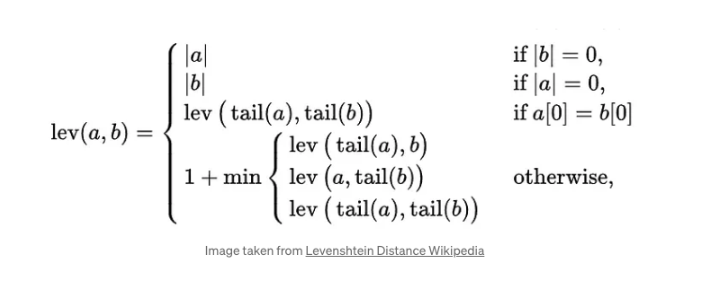

In [3]:
def direct_lev(a, b):
    """
    Calculates the Levenshtein distance between two strings.
    This is the minimum number of single-character edits (insertions, deletions, or substitutions)
    required to change string 'a' into string 'b'.
    
    Parameters
    ----------
    a : str
        The first string to compare.
    b : str
        The second string to compare.
    
    Returns
    -------
    int
        The Levenshtein distance between 'a' and 'b'.
    """
    
    if len(b) == 0:
        return len(a)
    elif len(a) == 0:
        return len(b)
    elif a[0] == b[0]:
        return lev(a[1:],b[1:])
    else:
        return 1 + min([lev(a[1:], b), lev(a, b[1:]), lev(a[1:], b[1:])])
    

def lev(a, b):
    """
    Calculates the Levenshtein distance between two strings.
    This is the minimum number of single-character edits (insertions, deletions, or substitutions)
    required to change string 'a' into string 'b'.
    
    Parameters
    ----------
    a : str
        The first string to compare.
    b : str
        The second string to compare.
    
    Returns
    -------
    int
        The Levenshtein distance between 'a' and 'b'.
    """
    size_x = len(a) + 1
    size_y = len(b) + 1
    matrix = [[0] * size_y for _ in range(size_x)]
    for x in range(size_x):
        matrix [x][0] = x
    for y in range(size_y):
        matrix [0][y] = y

    for x in range(1, size_x):
        for y in range(1, size_y):
            if a[x-1] == b[y-1]:
                matrix [x][y] = min(
                    matrix[x-1][y] + 1,
                    matrix[x-1][y-1],
                    matrix[x][y-1] + 1
                )
            else:
                matrix [x][y] = min(
                    matrix[x-1][y] + 1,
                    matrix[x-1][y-1] + 1,
                    matrix[x][y-1] + 1
                )
    return (matrix[size_x - 1][size_y - 1])


def lev_similarity(a, b):
    n_changes = lev(a, b)
    return n_changes/max([len(a), len(b)])

## 2. Cosine similarity

#### Using a Sentence Transformer 

In [4]:
model_sentence_embedding = SentenceTransformer('all-MiniLM-L6-v2')


def embedding_sentence_cosine_similarity(a, b):

    # Generate embeddings for two example sentences
    embeddings = model_sentence_embedding.encode([a, b])

    # Compute cosine similarity
    similarity = cosine_similarity(
        embeddings[0].reshape(1, -1), 
        embeddings[1].reshape(1, -1)
        )[0][0]
    
    return similarity 

#### Using Google's lightweight encoder 

In [5]:

# Load the Universal Sentence Encoder's TF Hub module
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

def embedding_cosine_similarity(a, b):
    
    embeddings = embed([a, b])
    return cosine_similarity(embeddings[0:1], embeddings[1:2])[0][0]


2023-06-14 20:09:26.592105: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-14 20:09:26.596662: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-14 20:09:26.599333: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-14 20:09:26.602306: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

## 3. Jaccard

In [6]:
def jaccard_similarity(a, b):
    """Calculate the Jaccard Similarity between two sentences."""
    set1 = set(a.split())
    set2 = set(b.split())
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union

## 4. BLEU

In [40]:
# modified n-gram precision
def bleu_similarity(a, b):
    """Calculate the modified n-gram precision between two sentences."""
    return sentence_bleu([a.split()], b.split())

## 5. Sentence embedding: BERT

Using this approach we can embed eaxch sentence and compare the whole text as an average of the sentences involved

In [8]:
from transformers import BertModel, BertTokenizer
import torch
from scipy.spatial.distance import cosine

bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

def embedding_bert_similarity(a, b):
    
    inputs_a = bert_tokenizer(a, return_tensors='pt')
    inputs_b = bert_tokenizer(b, return_tensors='pt')
    
    with torch.no_grad():
        outputs_a = bert_model(**inputs_a)
        outputs_b = bert_model(**inputs_b)
        
    embedding_a = outputs_a.last_hidden_state[0, 0, :].numpy()
    embedding_b = outputs_b.last_hidden_state[0, 0, :].numpy()
    
    return 1 - cosine(embedding_a, embedding_b)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## 6. BM25

In [35]:
from rank_bm25 import BM25Okapi

def bm_25_smiliarity(a, b):
    # Tokenize sentences
    tokens1 = a.split(" ")
    tokens2 = b.split(" ")

    # Create corpus
    corpus = [tokens1, tokens2]
    bm25 = BM25Okapi(corpus)

    # Use sentence1 as the query
    query = tokens1

    scores = bm25.get_scores(query)
    return scores[1]

## 7. CrossEncoders
Cross Encoders are not sentence based. 

In [78]:
from sentence_transformers.cross_encoder import CrossEncoder

# Pre-trained cross encoder
model_crossencoder = CrossEncoder('cross-encoder/stsb-distilroberta-base')

def crossencoder_similarity(a, b):
    
    similarity_score = model_crossencoder.predict([a, b])
    
    return similarity_score

# PIPELINE

In [103]:
import time
import numpy as np
import itertools

def uni_sentence_similairty(a, b, display_results=True):
    a = cleaning_pipeline(a)
    b = cleaning_pipeline(b)

    start_time = time.time()

    lev_s = lev_similarity(a, b)
    lev_end_time = time.time()

    cos_sen_s = embedding_sentence_cosine_similarity(a, b)
    cos_s_end_time = time.time()

    cos_s = embedding_cosine_similarity(a, b)
    cos_end_time = time.time()

    jac_s = jaccard_similarity(a, b)
    jac_end_time = time.time()

    bleu_s = bleu_similarity(a, b)
    bleu_end_time = time.time()

    bert_s = embedding_bert_similarity(a, b)
    bert_end_time = time.time()

    bm25_s = bm_25_smiliarity(a, b)
    bm25_end_time = time.time()
    
    cre_s = crossencoder_similarity(a, b)
    cre_s_end_time = time.time()

    if display_results == True:
        print(f"Levenshtein Similarity: {lev_s}, Time Taken: {lev_end_time - start_time} seconds")
        print(f"Cosine Similarity: {cos_sen_s}, Time Taken: {cos_s_end_time - lev_end_time} seconds")
        print(f"GOOGLE Cosine Similarity: {cos_s}, Time Taken: {cos_end_time - cos_s_end_time} seconds")
        print(f"Jaccard Similarity: {jac_s}, Time Taken: {jac_end_time - cos_end_time} seconds")
        print(f"BLEU Score: {bleu_s}, Time Taken: {bleu_end_time - jac_end_time} seconds")
        print(f"BERT Score: {bert_s}, Time Taken: {bert_end_time - bleu_end_time} seconds")
        print(f"BM25 Score: {bm25_s}, Time Taken: {bm25_end_time - bert_end_time} seconds")
        print(f"Cross Encoder Score: {cre_s}, Time Taken: {cre_s_end_time - bm25_end_time} seconds")
    
    return [lev_s, cos_sen_s, cos_s, jac_s, bleu_s, bert_s, bm25_s, cre_s]

def similarity_pipeline(a, b, split_sentences = True, display_results = False):
    
    if split_sentences == True: 
        sim = []
        a_sentences = nltk.sent_tokenize(a)
        b_sentences = nltk.sent_tokenize(b)
        
        for a_x in a_sentences:
            sim_max = -np.inf 
            sim_x = []
            for b_x in b_sentences:
                sim_x.append(uni_sentence_similairty(a_x, b_x, display_results))
            
            sim.append(sim_x)
                
#         for a_x, b_x in itertools.product(a_sentences, b_sentences):
#             print(a_x, b_x)
#             sim_x = uni_sentence_similairty(a_x, b_x, display_results)
#             sim.append(sim_x)
    else:
        sim = uni_sentence_similairty(a, b, display_results)

    return np.array(sim)


In [106]:
# Example usage - 1 sentence 
a = "This is a sample text."
b = "This is another sample text."
x = similarity_pipeline(a, b, split_sentences = False, display_results = False)
x

/usr/local/lib/python3.8/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.8/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


array([ 4.21052632e-001,  8.77490878e-001,  7.88602114e-001,
        6.66666667e-001,  1.13342269e-154,  9.45505321e-001,
       -4.92182848e-001,  8.87399912e-001])

In [107]:
# Example usage - Multiple sentences
a = "This is a heart tumor. Thoracic mass in the left ventricle. Smooth cardiac boundaries."
b = "The heart looks normal. The margins of the heart are round"
c = "The heart looks not normal. The margins of the heart are not round, there appears to be a mass in the left ventricle."

similarity_pipeline(a, b)
print('\n')
similarity_pipeline(a, c)
print('\n')
similarity_pipeline(b, c)

/usr/local/lib/python3.8/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.8/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.8/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

/usr/local/lib/python3.8/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.8/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.8/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

/usr/local/lib/python3.8/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.8/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.8/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

array([[[ 0.00000000e+000,  1.00000000e+000,  1.00000000e+000,
          1.00000000e+000,  1.22133867e-077,  1.00000000e+000,
         -1.20707843e+000,  9.90040720e-001],
        [ 7.44680851e-001,  5.28863311e-001,  4.38585788e-001,
          1.11111111e-001,  1.12004072e-231,  7.91034818e-001,
         -3.78869565e-002,  2.93516010e-001]],

       [[ 8.42105263e-001,  4.74152446e-001,  3.68742734e-001,
          2.00000000e-001,  1.38429296e-231,  9.13890481e-001,
         -8.04718956e-002,  3.70526135e-001],
        [ 5.95744681e-001,  7.83289433e-001,  7.02412426e-001,
          4.28571429e-001,  5.02133385e-078,  7.71704555e-001,
         -4.38406211e-001,  6.70229435e-001]]])

# FAKE MEDICAL REPORT APPLICATION 

In [14]:
df = pd.read_csv('fake_report_data.csv', index_col=False, header=0)

In [15]:
df

,TRUE,PRED,Unnamed: 2
0,Findings\nThorax\nThe cardiovascular structure...,Findings\nThorax\nNo abnormalities are seen in...,EQUAL
1,Findings\nThorax\nThe cardiovascular structure...,Findings\nThorax\nMild atherosclerotic changes...,EQUAL
2,Thorax\nThe cardiovascular structures are norm...,Thorax\nNo abnormalities are seen in the cardi...,EQUAL
3,Findings\nThorax\nThe cardiovascular structure...,Findings\nThorax\nNo abnormalities are seen in...,DIFFERENT
4,Findings\nThorax\nThe cardiovascular structure...,Findings\nThorax\nThere are signs of mild athe...,DIFFERENT
5,Findings\nThorax\nThe cardiovascular structure...,Findings\nThorax\nThe cardiovascular structure...,NaN


In [114]:
# Applying them brutally over the text 
similar = np.empty((len(df), 8))
for idx, row in df.iterrows():
    print('\n', row[-1])
    similar[idx, :] = similarity_pipeline(row['TRUE'], row['PRED'], split_sentences = False)


 EQUAL

 EQUAL

 EQUAL

 DIFFERENT

 DIFFERENT

 nan


In [117]:
similar[:, 7]

array([0.81041449, 0.92835915, 0.93322247, 0.96450269, 0.8841728 ,
       0.9652704 ])